In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [15]:
from sklearn.metrics import roc_curve,auc

In [69]:
# Read data
trainData = pd.read_table("/Users/stevenzhai/Desktop/FTE4560/overTrain.csv", sep=",")
trainDX = trainData[trainData.columns.values[:-1]]
trainDY = trainData[["class"]]

testData = pd.read_table("/Users/stevenzhai/Desktop/FTE4560/NormalTest.csv", sep=",")
testDX = testData[testData.columns.values[:-1]]
testDY = testData[["class"]]

#Add a column of 1 for the X
trainDX['Attr0'] = 1.0
testDX['Attr0'] = 1.0

# Transform the trainDY and testDY into two columns
trainDY["class2"] = 0
testDY["class2"] = 0

for i in range(949):
    if trainDY.iloc[i,0] == 0.0:
        trainDY.iloc[i,0] = 1
        trainDY.iloc[i,1] = 0
    else:
        trainDY.iloc[i,0] = 0
        trainDY.iloc[i,1] = 1
        
for j in range(151):
    if testDY.iloc[j,0] == 0.0:
        testDY.iloc[j,0] = 1
        testDY.iloc[j,1] = 0
    else:
        testDY.iloc[j,0] = 0
        testDY.iloc[j,1] = 1

<ipython-input-69-4ca72f9d5183>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainDY["class2"] = 0
<ipython-input-69-4ca72f9d5183>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDY["class2"] = 0
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [5]:
# Define the softmax function
def softmax(X):
    
    num_sample, num_class = X.shape
    for i in range(num_sample):
        denom = np.exp(X[i]).sum()
        X[i] = np.exp(X[i])/denom
    return(X)

In [6]:
# Define gradient descent for softmax without regularization
# k implies the number of classes
def gradientDescent(X,Y,k):
    dataMatrix = np.mat(X)
    classMatrix = np.mat(Y)
    num_sample, num_parameter = dataMatrix.shape
    weight1 = np.ones([num_parameter,k])
    weight2 = np.ones([num_parameter,k])
    step_size = 1
    max_iter = 2000
    episilon = 0.000001
    num_iter = 0
    los = []
    while(num_iter < max_iter):
        num_iter += 1
        weight2 = weight1
        y = softmax(dataMatrix*weight1)
        error = y - classMatrix
        weight1 = weight1 - (step_size)*dataMatrix.transpose()*error/num_sample
        if (abs(weight2[:,0]-weight1[:,0]) < episilon).all():
            break
    return weight1

In [58]:
weight = gradientDescent(trainDX,trainDY,2)

In [18]:
result = softmax(trainDX.to_numpy()*t)
temp_row, temp_col = result.shape
for i in range(temp_row):
    if result[i,0] < result[i,1]:
        result[i,0] = 0
        result[i,1] = 1
    else:
        result[i,0] = 1
        result[i,1] = 0

match = 0

for i in range(949):
    if np.mat(trainDY)[i,0] == 0 and result[i,0] == 0:
        match+=1


result.shape

(949, 2)

In [31]:
def soft_max(train_X,train_Y,test_X,test_Y):
    temp_weight = gradientDescent(train_X,train_Y,2)
    pred_train_Y = pd.DataFrame(softmax(train_X.to_numpy()*temp_weight))
    temp_row, temp_col = pred_train_Y.shape
    #classify the prediction results for training set
    for i in range(temp_row):
        if pred_train_Y.iloc[i,0] <= pred_train_Y.iloc[i,1]:
            pred_train_Y.iloc[i,0] = 0
            pred_train_Y.iloc[i,1] = 1
        else:
            pred_train_Y.iloc[i,0] = 1
            pred_train_Y.iloc[i,1] = 0
    
    TP_train = 0
    FP_train = 0
    TN_train = 0
    FN_train = 0
    #calculate TP,FP,TN,FN
    for j in range(temp_row):
        if (pred_train_Y.iloc[j,0] == 0 and train_Y.iloc[j,0] == 0):
            TP_train += 1
        elif (pred_train_Y.iloc[j,0] == 0 and train_Y.iloc[j,0] == 1):
            FP_train += 1
        elif (pred_train_Y.iloc[j,0] == 1 and train_Y.iloc[j,0] == 1):
            TN_train += 1
        else:
            FN_train += 1
            
    train_accuracy = (TP_train + TN_train)/(TP_train + FP_train + TN_train + FN_train)
    train_precision = TP_train/(TP_train + FP_train)
    train_recall = TP_train/(TP_train + FN_train)
    train_F1_score = 2*train_precision*train_recall/(train_precision+train_recall)
    
    #classify the prediction results for the test set
    pred_test_Y = pd.DataFrame(softmax(test_X.to_numpy()*temp_weight))
    temp_row2, temp_col2 = pred_test_Y.shape
    for m in range(temp_row2):
        if pred_test_Y.iloc[m,0] <= pred_test_Y.iloc[m,1]:
            pred_test_Y.iloc[m,0] = 0
            pred_test_Y.iloc[m,1] = 1
        else:
            pred_test_Y.iloc[m,0] = 1
            pred_test_Y.iloc[m,1] = 0
            
    TP_test = 0
    FP_test = 0
    TN_test = 0
    FN_test = 0
    #calculate TP,FP,TN,FN
    for n in range(temp_row2):
        if (pred_test_Y.iloc[n,0] == 0 and test_Y.iloc[n,0] == 0):
            TP_test += 1
        elif (pred_test_Y.iloc[n,0] == 0 and test_Y.iloc[n,0] == 1):
            FP_test += 1
        elif (pred_test_Y.iloc[n,0] == 1 and test_Y.iloc[n,0] == 1):
            TN_test += 1
        else:
            FN_test += 1
    
    test_accuracy = (TP_test + TN_test)/(TP_test + TN_test + FN_test + FP_test)
    test_precision = TP_test/(TP_test + FP_test)
    test_recall = TP_test/(TP_test + FN_test)
    test_F1_score = 2*test_precision*test_recall/(test_precision+test_recall)
    
    return(train_accuracy,train_precision,train_recall,train_F1_score,test_accuracy,test_precision,test_recall,test_F1_score)

In [32]:
soft_max(trainDX,trainDY,testDX,testDY)

(0.7818756585879874,
 0.7096774193548387,
 0.1,
 0.1752988047808765,
 0.6754966887417219,
 0.5128205128205128,
 0.7843137254901961,
 0.6201550387596899)

In [59]:
prob = (trainDX.to_numpy()*weight[:,1] - np.min(trainDX.to_numpy()*weight[:,1]))/(np.max(trainDX.to_numpy()*weight[:,1])-np.min(trainDX.to_numpy()*weight[:,1]))
prob2 = (testDX.to_numpy()*weight[:,1] - np.min(testDX.to_numpy()*weight[:,1]))/(np.max(testDX.to_numpy()*weight[:,1])-np.min(testDX.to_numpy()*weight[:,1]))

In [64]:
y1 = (trainDY.to_numpy()[:,1] - np.min(trainDY.to_numpy()[:,1]))/(np.max(trainDY.to_numpy()[:,1])-np.min(trainDY.to_numpy()[:,1]))
y2 = (testDY.to_numpy()[:,1] - np.min(testDY.to_numpy()[:,1]))/(np.max(testDY.to_numpy()[:,1])-np.min(testDY.to_numpy()[:,1]))
y2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


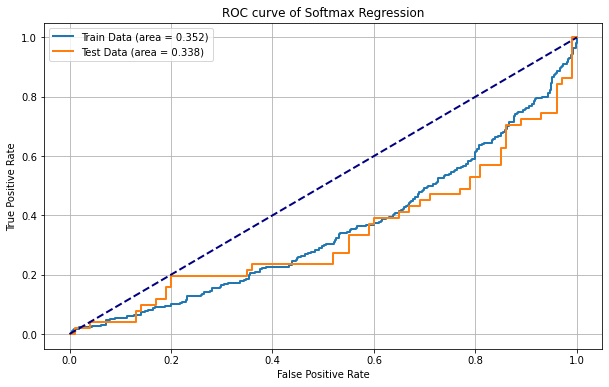

In [65]:
#Plot the ROC curve
plt.figure(figsize=(10,6))
FPR,TPR,threshold = roc_curve(trainDY.iloc[:,1],prob,1)
FPR2,TPR2,threshold2 = roc_curve(testDY.iloc[:,1],prob2,1)
roc_auc = auc(FPR,TPR)
roc_auc2 = auc(FPR2,TPR2)
plt.plot(FPR,TPR,lw=2,label = 'Train Data'+' (area = %0.3f)'%roc_auc)
plt.plot(FPR2,TPR2,lw=2,label = 'Test Data'+' (area = %0.3f)'%roc_auc2)
plt.plot([0,1],[0,1],color = 'navy',lw = 2, linestyle = '--')
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of Softmax Regression")
plt.legend()
plt.show()

In [83]:
# Define gradient descent for softmax with regularization
# k implies the number of classes
def gradientDescent_reg(X,Y,k,lam):
    dataMatrix = np.mat(X)
    classMatrix = np.mat(Y)
    num_sample, num_parameter = dataMatrix.shape
    weight1 = np.ones([num_parameter,k])
    weight2 = np.ones([num_parameter,k])
    step_size = 1
    max_iter = 20
    episilon = 0.000001
    num_iter = 0
    los = []
    while(num_iter < max_iter):
        num_iter += 1
        weight2 = weight1
        y = softmax(dataMatrix*weight1)
        error = y - classMatrix
        weight1 = weight1 - (step_size)*(dataMatrix.transpose()*error+lam*weight1)/num_sample
        if (abs(weight2[:,0]-weight1[:,0]) < episilon).all():
            break
    return weight1

In [87]:
#Define cross-validation for logistic with regularization to test accuracy
def cross_validation_regularize(X,Y,lam):
    #Create the fold to save precision
    precision_train = []
    precision_vali = []
    recall_train = []
    recall_vali = []
    accuracy_train = []
    accuracy_vali = []
    # Set the seed
    np.random.seed(1)
    # Divide indices of data into 10 folds randomly
    row = X.shape[0]
    index = [int(i) for i in np.linspace(0, row-1, row)]
    random.shuffle(index)
    # Use 10-fold cross validation to estimate the error rate
    folds = 10
    for i in range(0, folds):
        # For each fold, calculate the accuracy
        vali_index = index[int(row/folds*i):int(row/folds*(i+1))]
        # Train set has 9 folds and validation set has 1 fold
        vali_x = X.iloc[vali_index]
        vali_y = Y.iloc[vali_index]
        train_x = X.iloc[list(set(index)-set(vali_index))]
        train_y = Y.iloc[list(set(index)-set(vali_index))]
        temp_weight = gradientDescent_reg(train_x,train_y,2,lam)
        #predict result for the train set
        pred_train_y = softmax(train_x.to_numpy()*temp_weight)
        pred_train_y = pd.DataFrame(pred_train_y)
        temp_row, temp_col = pred_train_y.shape
        for j in range(temp_row):
            if pred_train_y.iloc[j,0] <= pred_train_y.iloc[j,1]:
                pred_train_y.iloc[j,0] = 0
                pred_train_y.iloc[j,1] = 1
            else:
                pred_train_y.iloc[j,0] = 1
                pred_train_y.iloc[j,1] = 0
                
        TP_train = 0
        FP_train = 0
        FN_train = 0
        TN_train = 0
        
        for k in range(temp_row):
            if pred_train_y.iloc[k,0] == 0 and train_y.iloc[k,0] == 0:
                TP_train+=1
            elif pred_train_y.iloc[k,0] == 0 and train_y.iloc[k,0] == 1:
                FP_train+=1
            elif pred_train_y.iloc[k,0] == 1 and train_y.iloc[k,0] == 0:
                FN_train+=1
            else:
                TN_train+=1
        if (TP_train+FP_train != 0):
            precision_train.append(TP_train/(TP_train+FP_train))
        else:
            precision_train.append(0)
        
        recall_train.append(TP_train/(TP_train + FN_train))
        accuracy_train.append((TP_train+TN_train)/(TP_train+TN_train+FP_train+FN_train))
        #predict result for the test set
        pred_vali_y = softmax(vali_x.to_numpy()*temp_weight)
        pred_vali_y = pd.DataFrame(pred_vali_y)
        temp_row2,temp_col2 = pred_vali_y.shape
        for j in range(temp_row2):
            if pred_vali_y.iloc[j,0] <= pred_vali_y.iloc[j,1]:
                pred_vali_y.iloc[j,0] = 0
                pred_vali_y.iloc[j,1] = 1
            else:
                pred_vali_y.iloc[j,0] = 1
                pred_vali_y.iloc[j,1] = 0
        TP_vali = 0
        FP_vali = 0
        FN_vali = 0
        TN_vali = 0
        for k in range(temp_row2):
            if pred_vali_y.iloc[k,0] == 0 and vali_y.iloc[k,0] == 0:
                TP_vali+=1
            elif pred_vali_y.iloc[k,0] == 0 and vali_y.iloc[k,0] == 1:
                FP_vali+=1
            elif pred_vali_y.iloc[k,0] == 1 and vali_y.iloc[k,0] == 0:
                FN_vali+=1
            else:
                TN_vali+=1
        if(TP_vali+FP_vali != 0):
            precision_vali.append(TP_vali/(TP_vali+FP_vali))
        else:
            precision_vali.append(0)
        recall_vali.append(TP_vali/(TP_vali+FN_vali))
        accuracy_vali.append((TP_vali+TN_vali)/(TP_vali+TN_vali+FP_vali+FN_vali))
        
        
    F1_train = [2*precision_train[i]*recall_train[i]/(precision_train[i]+recall_train[i]) for i in range(len(precision_train)) if (precision_train[i]+recall_train[i]) != 0]    
    F1_vali = [2*precision_vali[i]*recall_vali[i]/(precision_vali[i]+recall_vali[i]) for i in range(len(precision_vali)) if precision_vali != None and (precision_vali[i]+recall_vali[i]) != 0]
    precision_vali = list(filter(None,precision_vali))
    return(np.mean(accuracy_train),np.mean(precision_train),np.mean(recall_train),np.mean(F1_train),np.mean(accuracy_vali),np.mean(precision_vali),np.mean(recall_vali),np.mean(F1_vali))

In [37]:
cross_validation_regularize(trainDX,trainDY,0)

(0.7817587685059644,
 0.698143208618615,
 0.10204195119685103,
 0.17749227710154752,
 0.7755431131019036,
 0.674074074074074,
 0.08814698988612032,
 0.16352970008883988)

In [88]:
def ten_CV_plot(train_x,train_y,para):
    accuracy = []
    precision = []
    recall = []
    F1 = []
    for i in np.linspace(0,para,6):
        k = cross_validation_regularize(train_x,train_y,i)
        accuracy.append(k[4])
        precision.append(k[5])
        recall.append(k[6])
        F1.append(k[7])
    fig = plt.figure()
    plt.xlabel("lambda")
    plt.ylabel("Rate")
    plt.grid()
    plt.ylim(0,1.2)
    plt.plot(np.linspace(0,para,6), precision,marker="o",markerfacecolor="brown",label="Precision")
    plt.plot(np.linspace(0,para,6),recall,marker="o",markerfacecolor="purple",label="Recall")
    plt.plot(np.linspace(0,para,6),F1,marker="o",markerfacecolor="burlywood",label="F1 Score")
    plt.plot(np.linspace(0,para,6),accuracy,marker="o",markerfacecolor="aliceblue",label="Accuracy")
    plt.title("Metrics of Softmax Regression with L2-norm")
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


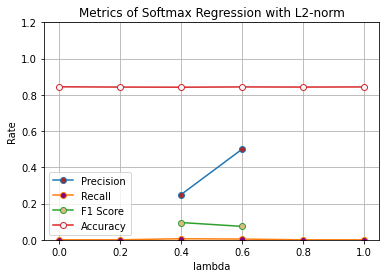

In [89]:
ten_CV_plot(trainDX,trainDY,1)

In [53]:
def soft_max_reg(train_X,train_Y,test_X,test_Y,lam):
    temp_weight = gradientDescent_reg(train_X,train_Y,2,lam)
    pred_train_Y = pd.DataFrame(softmax(train_X.to_numpy()*temp_weight))
    temp_row, temp_col = pred_train_Y.shape
    #classify the prediction results for training set
    for i in range(temp_row):
        if pred_train_Y.iloc[i,0] <= pred_train_Y.iloc[i,1]:
            pred_train_Y.iloc[i,0] = 0
            pred_train_Y.iloc[i,1] = 1
        else:
            pred_train_Y.iloc[i,0] = 1
            pred_train_Y.iloc[i,1] = 0
    
    TP_train = 0
    FP_train = 0
    TN_train = 0
    FN_train = 0
    #calculate TP,FP,TN,FN
    for j in range(temp_row):
        if (pred_train_Y.iloc[j,0] == 0 and train_Y.iloc[j,0] == 0):
            TP_train += 1
        elif (pred_train_Y.iloc[j,0] == 0 and train_Y.iloc[j,0] == 1):
            FP_train += 1
        elif (pred_train_Y.iloc[j,0] == 1 and train_Y.iloc[j,0] == 1):
            TN_train += 1
        else:
            FN_train += 1
            
    train_accuracy = (TP_train + TN_train)/(TP_train + FP_train + TN_train + FN_train)
    train_precision = TP_train/(TP_train + FP_train)
    train_recall = TP_train/(TP_train + FN_train)
    train_F1_score = 2*train_precision*train_recall/(train_precision+train_recall)
    
    #classify the prediction results for the test set
    pred_test_Y = pd.DataFrame(softmax(test_X.to_numpy()*temp_weight))
    temp_row2, temp_col2 = pred_test_Y.shape
    for m in range(temp_row2):
        if pred_test_Y.iloc[m,0] <= pred_test_Y.iloc[m,1]:
            pred_test_Y.iloc[m,0] = 0
            pred_test_Y.iloc[m,1] = 1
        else:
            pred_test_Y.iloc[m,0] = 1
            pred_test_Y.iloc[m,1] = 0
            
    TP_test = 0
    FP_test = 0
    TN_test = 0
    FN_test = 0
    #calculate TP,FP,TN,FN
    for n in range(temp_row2):
        if (pred_test_Y.iloc[n,0] == 0 and test_Y.iloc[n,0] == 0):
            TP_test += 1
        elif (pred_test_Y.iloc[n,0] == 0 and test_Y.iloc[n,0] == 1):
            FP_test += 1
        elif (pred_test_Y.iloc[n,0] == 1 and test_Y.iloc[n,0] == 1):
            TN_test += 1
        else:
            FN_test += 1
    
    test_accuracy = (TP_test + TN_test)/(TP_test + TN_test + FN_test + FP_test)
    test_precision = TP_test/(TP_test + FP_test)
    test_recall = TP_test/(TP_test + FN_test)
    test_F1_score = 2*test_precision*test_recall/(test_precision+test_recall)
    
    return(train_accuracy,train_precision,train_recall,train_F1_score,test_accuracy,test_precision,test_recall,test_F1_score)

In [54]:
soft_max_reg(trainDX,trainDY,testDX,testDY,0.6)

(0.7829293993677555,
 0.8181818181818182,
 0.08181818181818182,
 0.1487603305785124,
 0.6490066225165563,
 0.4868421052631579,
 0.7254901960784313,
 0.5826771653543308)

In [67]:
weight = gradientDescent_reg(trainDX,trainDY,2,0.6)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


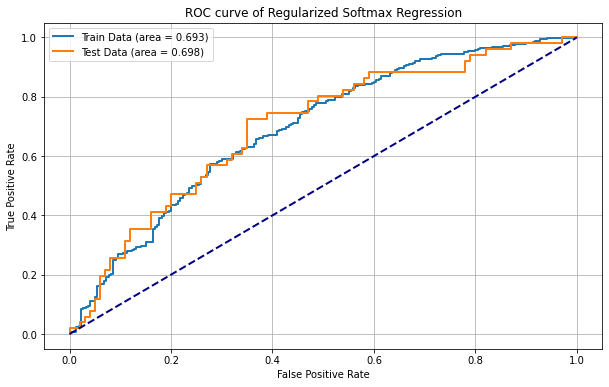

In [68]:
prob = (trainDX.to_numpy()*weight[:,0] - np.min(trainDX.to_numpy()*weight[:,0]))/(np.max(trainDX.to_numpy()*weight[:,0])-np.min(trainDX.to_numpy()*weight[:,0]))
prob2 = (testDX.to_numpy()*weight[:,1] - np.min(testDX.to_numpy()*weight[:,1]))/(np.max(testDX.to_numpy()*weight[:,1])-np.min(testDX.to_numpy()*weight[:,1]))

#Plot the ROC curve
plt.figure(figsize=(10,6))
FPR,TPR,threshold = roc_curve(trainDY.iloc[:,0],prob,1)
FPR2,TPR2,threshold2 = roc_curve(testDY.iloc[:,1],prob2,1)
roc_auc = auc(FPR,TPR)
roc_auc2 = auc(FPR2,TPR2)
plt.plot(FPR,TPR,lw=2,label = 'Train Data'+' (area = %0.3f)'%roc_auc)
plt.plot(FPR2,TPR2,lw=2,label = 'Test Data'+' (area = %0.3f)'%roc_auc2)
plt.plot([0,1],[0,1],color = 'navy',lw = 2, linestyle = '--')
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of Regularized Softmax Regression")
plt.legend()
plt.show()

